Purpose: Classify recipes using the machine learning techniques we practiced in class. Specifically, we will do the classification by cuisine.

Data: https://www.kaggle.com/c/whats-cooking/data

Outline:
1. Set up the data into a TensorFlow dataset
2. Build and compile the model
3. Classify! (hopefully...)

In [50]:
# imports
import json
import pandas as pd

import tensorflow as tf


import numpy as np
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

In [52]:
# read in data

with open("Data/train.json") as f:
    data = json.load(f)
df = pd.DataFrame(data)

#with open("Data/test.json") as f:
 #   data = json.load(f)
#df_test = pd.DataFrame(data)

In [53]:
df.groupby("cuisine").size()

cuisine
brazilian        467
british          804
cajun_creole    1546
chinese         2673
filipino         755
french          2646
greek           1175
indian          3003
irish            667
italian         7838
jamaican         526
japanese        1423
korean           830
mexican         6438
moroccan         821
russian          489
southern_us     4320
spanish          989
thai            1539
vietnamese       825
dtype: int64

In [9]:
categories = ["indian", "mexican", "thai"]

df = df[df["cuisine"].apply(lambda x: x in categories)]
df.head()

,id,cuisine,ingredients
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por..."
13,41995,mexican,"[ground cinnamon, fresh cilantro, chili powder..."
15,24717,indian,"[tumeric, vegetable stock, tomatoes, garam mas..."


In [54]:
type(df.iloc[3, 2])

list

In [55]:
# send column from list to str
df["ingredients"] = df["ingredients"].apply(lambda x: ' '.join(map(str, x)))

In [56]:
df

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,plain flour ground pepper salt tomatoes ground...
2,20130,filipino,eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallots cornflour cayenne pepper...
...,...,...,...
39769,29109,irish,light brown sugar granulated sugar butter warm...
39770,11462,italian,KRAFT Zesty Italian Dressing purple onion broc...
39771,2238,irish,eggs citrus fruit raisins sourdough starter fl...
39772,41882,chinese,boneless chicken skinless thigh minced garlic ...


In [57]:
le = LabelEncoder()
df["cuisine"] = le.fit_transform(df["cuisine"])
df.head()

,id,cuisine,ingredients
0,10259,6,romaine lettuce black olives grape tomatoes ga...
1,25693,16,plain flour ground pepper salt tomatoes ground...
2,20130,4,eggs pepper salt mayonaise cooking oil green c...
3,22213,7,water vegetable oil wheat salt
4,13162,7,black pepper shallots cornflour cayenne pepper...


In [70]:
len(le.classes_)

20

In [59]:
# set up finished, now onto a TensorFlow dataset

data = tf.data.Dataset.from_tensor_slices((df["ingredients"], df["cuisine"]))

for cuisine, ingredients in data.take(5):
    print(cuisine)
    print(ingredients)
    print("")

tf.Tensor(b'romaine lettuce black olives grape tomatoes garlic pepper purple onion seasoning garbanzo beans feta cheese crumbles', shape=(), dtype=string)
tf.Tensor(6, shape=(), dtype=int32)

tf.Tensor(b'plain flour ground pepper salt tomatoes ground black pepper thyme eggs green tomatoes yellow corn meal milk vegetable oil', shape=(), dtype=string)
tf.Tensor(16, shape=(), dtype=int32)

tf.Tensor(b'eggs pepper salt mayonaise cooking oil green chilies grilled chicken breasts garlic powder yellow onion soy sauce butter chicken livers', shape=(), dtype=string)
tf.Tensor(4, shape=(), dtype=int32)

tf.Tensor(b'water vegetable oil wheat salt', shape=(), dtype=string)
tf.Tensor(7, shape=(), dtype=int32)

tf.Tensor(b'black pepper shallots cornflour cayenne pepper onions garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf', shape=(), dtype=string)
tf.Tensor(7, shape=(), dtype=int3

In [60]:
data = data.shuffle(buffer_size = len(data))

train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [62]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

max_tokens = 1500 # how many words to keep track of

sequence_length = 30 # length, probably need to increase

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length)

In [63]:
ingredients = train.map(lambda x, y: x)
vectorize_layer.adapt(ingredients)

In [64]:
def vectorize_ingr(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_ingr)
val_vec   = val.map(vectorize_ingr)
test_vec  = test.map(vectorize_ingr)

In [65]:
list(train_vec.take(2))

[(<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
  array([[ 14,   2,  19,  43,  17,  18,  38,  73,  22,  89,  10,  15,   5,
           20,   2, 590, 522, 194,   6,  16,   2,   3, 331,   0,   0,   0,
            0,   0,   0,   0]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([16])>),
 (<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
  array([[ 52,   3, 115,  83,  12,  44, 454, 134, 141,  93,  48,  13,   4,
          417,  49,   5,  23, 169, 193, 721,  89, 192, 124, 488, 442, 249,
           20,  49, 141,  93]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([9])>)]

In [32]:
# time to model

In [71]:
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 20, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(le.classes_))]
)

In [72]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [73]:
history = model.fit(train_vec, epochs = 3, validation_data = val_vec)

Epoch 1/3
27841/27841 [==============================] - 30s 1ms/step - loss: 2.0194 - accuracy: 0.4261 - val_loss: 1.1208 - val_accuracy: 0.6714
Epoch 2/3
27841/27841 [==============================] - 33s 1ms/step - loss: 1.1160 - accuracy: 0.6710 - val_loss: 0.9244 - val_accuracy: 0.7315
Epoch 3/3
27841/27841 [==============================] - 32s 1ms/step - loss: 0.9745 - accuracy: 0.7148 - val_loss: 0.8846 - val_accuracy: 0.7423


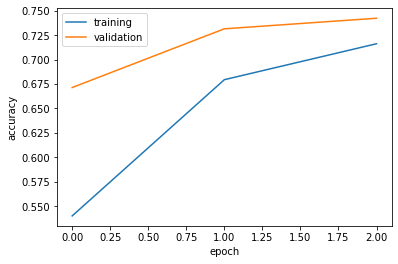

In [74]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [75]:
model.evaluate(test_vec)

7956/7956 [==============================] - 5s 609us/step - loss: 0.8281 - accuracy: 0.7588


[0.8281395435333252, 0.7587984204292297]

In [80]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

In [78]:
while len(vocab) < 2000:
    vocab += " "

In [82]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,0.319362,0.018485
1,[UNK],0.603366,-0.246011
2,pepper,0.146945,0.033100
3,salt,0.270252,-0.302396
4,oil,1.214424,1.060065
...,...,...,...
1495,mochiko,1.122289,0.045361
1496,merguez,0.794679,0.132758
1497,mccormick,0.358403,-0.026068
1498,masoor,0.454460,-0.161817


In [83]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()